# Adversarial Search: Playing Dots and Boxes


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play the game Dots and Boxes:

> "Dots and Boxes is a pencil-and-paper game for two players. The game starts with an empty grid of dots. Usually two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. A player who completes the fourth side of a 1x1 box earns one point and takes another turn. A point is typically recorded by placing a mark that identifies the player in the box, such as an initial. The game ends when no more lines can be placed. The winner is the player with the most points. The board may be of any size grid." (see [Dots and Boxes on Wikipedia](https://en.wikipedia.org/wiki/Dots_and_Boxes))

You can play Dots and Boxes [here](https://www.math.ucla.edu/~tom/Games/dots&boxes.html).

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

In [55]:
# Your code/answer goes here.

How big is the state space? Give an estimate and explain it.

In [56]:
# Your code/ answer goes here.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [57]:
# Your code/ answer goes here.

## Task 2: Game Environment and Random Agent [30 point]

You need to think about a data structure to represent the board meaning he placed lines and who finished what box. There are many options. Let's represent the board using a simple dictionary where `n` and `m` represents the number of dots horizontaly and vertically, respectively. Everybody needs to use the same representation so we can let agents play against each other later. 

In [58]:
board = {
    'n': 4,  ### hoizontal dots
    'm': 4   ### vertical dots
}

def draw_line(board, orientation, row, col):
    """
    Place a line on an exiting board.
       
    Parameters
    ----------
    board: dict
        the board
    orientation: str
        either 'h' or 'v' for horizontal or vertical
    row, col: int
        index of the starting dot for the line (starting with 0)
    
    """
    
    if orientation not in ['h', 'v']:
        return False
        
    if row < 0 or col < 0:
        return False
        
    if row >= board['n'] + (orientation == 'v') or col >= board['m'] + (orientation == 'h'):
        return False
        
    if (orientation, row, col) in board:
        return False
            
    board[(orientation, row, col)] = True
    return True
    





Write code to display the board. **Bonus point: Post your visualization code with an example output to the discussion board. The best visualization will earn you bonus participation points in this class.**

In [59]:
# Your code/ answer goes here.
#https://stackoverflow.com/questions/35109590/how-to-graph-nodes-on-a-grid-in-networkx
import matplotlib.pyplot as plt
import networkx as nx
edge_colors = ['blue', 'red']
edgeLabels = {}
# functions  to create empty visualization
def drawBoard(G,edgeLabels):

    colors = nx.get_edge_attributes(G,'color').values()
    labels = nx.get_edge_attributes(G,'label').values()
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos=pos,
        node_color='lightgreen',
        edge_color=colors,
        width=8,
        with_labels=True,
        node_size=600)
    nx.draw_networkx_edge_labels(G, pos, edgeLabels)

def createEmptyBoard(G,edgeLabels):
    plt.figure(figsize=(6,6))
    for edge in G.edges():
        G.remove_edge(*edge)
    # Set margins for the axes so that nodes aren't clipped
    #drawBoard(G,edgeLabels)

def addEdge(G,board, x,y, orientation,player,edgeLabels):
    #set the colors of the edges
    color=edge_colors[player]
    label=player
    draw_line(board, orientation, x,y)

    #add the edge to the graph
    if orientation == 'h':
        G.add_edge((x,y), (x,y+1), color=color, label=label)
        edgeLabels.update({((x,y),(x,y+1)):player})
    else:
        G.add_edge((x,y), (x+1,y), color=color, label=label)
        edgeLabels.update({((x,y),(x+1,y)):player})
    #drawBoard(G,edgeLabels)
    return board

def removeEdge(G,board, x,y, orientation,edgeLabels):
    del board[(orientation, x,y)]
    #add the edge to the graph
    if orientation == 'h':
        G.remove_edge((x,y), (x,y+1))
        edgeLabels.update({((x,y),(x,y+1)):""})
    else:
        G.remove_edge((x,y), (x+1,y))
        edgeLabels.update({((x,y),(x+1,y)):""})
    #drawBoard(G,edgeLabels)
    return board
# G = nx.grid_2d_graph(board['n'], board['m'])
# createEmptyBoard(G,edgeLabels)
# addEdge(G,board, 0,0, 'h',1,edgeLabels)
# removeEdge(G,board, 0,0, 'h',edgeLabels)
# drawBoard(G,edgeLabels)
# addEdge(G, 0,0, 'v',1)
#
#
# addEdge(G, 0,1, 'v',1)
# addEdge(G, 1,0, 'h',0)
#
# addEdge(G,2,2, 'h',0)
# addEdge(G,2,2, 'v',1)
# addEdge(G,2,3, 'v',1)
# addEdge(G,3,2, 'h',0)
# print(board)


Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows as stored in the board).

In [60]:
# Your code/ answer goes here.
def result(board, draw_line):
    return board



def utility(board):
    #check who has more boxes and award that player a point
    player1=0
    player0=0
    #print(board)
    for i in range(board['n']-1):
        for j in range(board['m']-1):
            #if the all sides of the box exist and are true
            if (('h', i, j) in board and board['h',i,j]==True)\
                    and (('h', i+1, j) in board and board['h',i+1,j]==True) \
                    and (('v', i, j) in board and board['v',i,j]==True)\
                    and (('v', i, j+1) in board and board['v',i,j+1]==True):

                # then determine which player completed the box by checking which was most recently
                # added to the list of moves
                mostRecentMove = list(board.keys()).index(('h', i, j))
                if(list(board.keys()).index(('h', i+1, j)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('h', i+1, j))
                if(list(board.keys()).index(('v', i, j+1)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('v', i, j+1))
                if(list(board.keys()).index(('v', i, j)) > mostRecentMove):
                    mostRecentMove= list(board.keys()).index(('v', i, j))

                #set the most recent move to the most recent move index
                value_at_index=list(board.keys())[mostRecentMove]

                #determine the the player whos number is on the edge that completed the box
                if(value_at_index[0]=='h'):
                    player = (edgeLabels[(value_at_index[1],value_at_index[2]),(value_at_index[1],value_at_index[2]+1)])
                if(value_at_index[0]=='v'):
                    player = (edgeLabels[(value_at_index[1],value_at_index[2]),(value_at_index[1]+1,value_at_index[2])])

                #increment the player that completed the box
                if(player==1):
                    player1+=1
                else:
                    player0+=1
    #if player1 has more boxes, return 1
    if player1>player0:
        return 1
    #if player0 has more boxes, return 0
    elif player0>player1:
        return 0
    #if they are equal, return -1
    else:
        return -1
def actions(board):
    #initialize list of actions to none
    acts=[]

    #check if there are any available actions
    for i in range (board['n']-1):
        for j in range (board['m']-1):
            orientation = 'h'
            if (orientation, i, j) not in board:
                acts.append((orientation, i, j))
            orientation = 'v'
            if (orientation, i, j) not in board:
                acts.append((orientation, i, j))

    #Add bottom and right side of board to possible actions
    for i in range(board['n']-1):
        if("v",i,board['m']-1) not in board:
            acts.append(("v",i,board['m']-1))
    for i in range(board['m']-1):
        if("h",board['n']-1,i) not in board:
            acts.append(("h",board['n']-1,i))
    return acts



def terminal(board):
    #if there are no more actions, then the game is over
    if actions(board)==[]:
        return True
    else:
        return False

#print(actions(board))



#utility(board)

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [61]:
# Your code/ answer goes here.
import random

def random_player(board, player,edgeLabels):
    #load all possible actions into a list
    acts=actions(board)

    #randomly choose an action from the list
    act=acts[random.randint(0,len(acts)-1)]

    #execute and add the random edge to the board
    addEdge(G2,board, act[1],act[2], act[0],player,edgeLabels)


#reset the colors and labels on the visualization
edge_colors = ['blue', 'red']
edgeLabels = {}

#set the board height and width
board2 = {
    'n': 6,  ### hoizontal dots
    'm': 6   ### vertical dots
}

#create empty visualization
G2 = nx.grid_2d_graph(board2['n'], board2['m'])
createEmptyBoard(G2,edgeLabels)

#loop while not terminal
while not terminal(board2):
    random_player(board2, 1,edgeLabels)
    if not terminal(board2):
        random_player(board2, 0,edgeLabels)

#print the winner
utility(board2)

#clear the visualization
G2.clear()

<Figure size 432x432 with 0 Axes>

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

* After testing on various board sizes, I found that with a small board, with 9 possible boxes, the player who goes first won around 90% of the time. However, with a larger board, with 36 possible boxes, each player wins about 50% of the time.

In [62]:
# Your code/ answer goes here.
def play(limit):
    player1wins=0
    player0wins=0
    ties=0
    for i in range(limit):
        edgeLabels = {}
        board2 = {
            'n': 6,  ### hoizontal dots
            'm': 6   ### vertical dots
        }
        G2 = nx.grid_2d_graph(board2['n'], board2['m'])
        createEmptyBoard(G2,edgeLabels)

        #loop until terminal state
        while not terminal(board2):
            random_player(board2, 1,edgeLabels)
            if not terminal(board2):
                random_player(board2, 0,edgeLabels)
        #if winner is player 1, increment player1wins
        if utility(board2)==1:
            player1wins+=1
        #if winner is player 0, increment player0wins
        elif utility(board2)==0:
            player0wins+=1
        #if utility is tie, increment ties
        else:
            ties+=1

        #clear graph for next iteration
        G2.clear()

        #close the graph
        plt.close()

    #Print the results
    print("Player 1 wins ",player1wins)
    print("Player 0 wins ",player0wins)
    print("Ties ",ties)


play(1000)


Player 1 wins  552
Player 0 wins  448
Ties  0


## Task 3: Minimax Search with Alpha-Beta Pruning [30 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for larger board may be too large. You can experiment with smaller boards.

(-1, -1)
{'n': 4, 'm': 4}


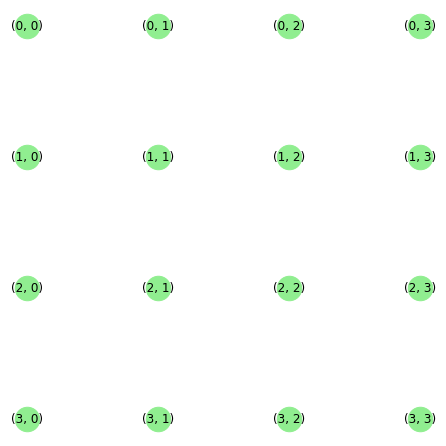

In [89]:
# Your code/ answer goes here.
def minimax(G,board, depth, isMax,edgeLabels):
    score = utility(board)

    # If Maximizer has won the game return his/her
    # evaluated score
    if (score == 1) :
        print("Maximizer has won the game")
        return score

    # If Minimizer has won the game return his/her
    # evaluated score
    if (score == 0) :
        print("Minimizer has won the game")
        return score

    # If there are no more moves and no winner then
    # it is a tie
    if (utility(board) == -1) :
        print("Game is a tie")
        return 0

    # If this maximizer's move
    if (isMax) :
        best = -1000

        # Traverse all cells
        for i in board['n']-1 :
            for j in board['m']-1 :
                for c in range(2):
                # Check if cell is empty
                    if c == 1:
                        orientation = 'v'
                    else:
                        orientation = 'h'


                    if (orientation, i, j) not in board:
                        addEdge(G,board,i,j,orientation,1,edgeLabels)

                    # Call minimax recursively and choose
                    # the maximum value
                        best = max( best, minimax(board,
                                              depth + 1,
                                              not isMax) )

                    # Undo the move
                        removeEdge(G,board,i,j,orientation,edgeLabels)
        return best

    # If this minimizer's move
    else :
        best = 1000

        # Traverse all cells
        for i in range(board['n']-1) :
            for j in range(board['m']-1) :
                for c in range(2):
                # Check if cell is empty
                    if c == 1:
                        orientation = 'v'
                    else:
                        orientation = 'h'


                    if (orientation, i, j) not in board:
                        addEdge(G,board,i,j,orientation,1,edgeLabels)

                    # Call minimax recursively and choose
                    # the maximum value
                        best = min( best, minimax(board,
                                              depth + 1,
                                              not isMax) )

                    # Undo the move
                        removeEdge(G,board,i,j,orientation,edgeLabels)
        return best

# This will return the best possible move for the player
def findBestMove(board,G) :
    bestVal = -1000
    bestMove = (-1, -1)

    # Traverse all cells, evaluate minimax function for
    # all empty cells. And return the cell with optimal
    # value.

    for i in range(board['n']-1) :
        for j in range(board['m']-1) :
                for c in range(2):
                # Check if cell is empty
                    if c == 1:
                        orientation = 'v'
                    else:
                        orientation = 'h'


                    if (orientation, i, j) not in board:
                        addEdge(G,board,i,j,orientation,1,edgeLabels)

                        moveVal = minimax(G,board,0,False,edgeLabels)

                        removeEdge(G,board,i,j,orientation,edgeLabels)

                        if(moveVal > bestVal) :
                            bestMove = (orientation,i, j)
                            bestVal = moveVal

    print("The value of the best Move is :", bestVal)

    print(bestMove)
    return bestMove

edgeLabels = {}
board = {
    'n': 4,  ### hoizontal dots
    'm': 4   ### vertical dots
}
G = nx.grid_2d_graph(board['n'], board['m'])
createEmptyBoard(G,edgeLabels)
# while not terminal(board):
#     bestMove = findBestMove(board,G)
#     addEdge(G,board,bestMove[1],bestMove[2],bestMove[0],1,edgeLabels)
#     if not terminal(board):
#         bestMove = findBestMove(board,G)
#         addEdge(G,board,bestMove[1],bestMove[2],bestMove[0],0,edgeLabels)
print(bestMove)
drawBoard(G,edgeLabels)
print(board)

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [64]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board make the board larger. What is the largest board you can solve?

In [65]:
# Your code/ answer goes here.

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [66]:
# Your code/ answer goes here.

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

In [67]:
# Your code/ answer goes here.

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [68]:
# Your code/ answer goes here.

## Task 4: Heuristic Alpha-Beta Tree Search [30 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [69]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [70]:
# Your code/ answer goes here.

Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [71]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [72]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [73]:
# Your code/ answer goes here.

## Tournament task [+1 to 5% bonus on your course grade; will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [74]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($5 \times 5$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [75]:
# Your code/ answer goes here.